# Parameters

In [0]:
source_folder = '/content/drive/My Drive/COMP_4211_Project/Data/Phase_1'
destination_folder = '/content/drive/My Drive/COMP_4211_Project/Models/Phase_1/Word2Vec'

# Libraries

In [2]:
!pip install sacremoses

     |████████████████████████████████| 890kB 9.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=9cd376fa82ead8eeafa356c53b67a083857231531d4e4a4d9340f127aaf8f416
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator

# Models

import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Preliminaries

In [0]:
# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize='moses', lower=True, include_lengths=True, batch_first=True)
fields = [('label', label_field), ('title', text_field), ('text', text_field), ('titletext', text_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv', test='test.csv',
                                           format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)

# Vocabulary

text_field.build_vocab(train, min_freq=3)

# Models

In [0]:
class OurEncoder(nn.Module):
    
    def __init__(self, dimension):
        super(OurEncoder, self).__init__()
        
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.5)
    
    def forward(self, text_emb, text_len):
        
        packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)

        return self.drop(out_reduced)

In [0]:
class OurClassifier(nn.Module):

    def __init__(self, dimension):
        super(OurClassifier, self).__init__()

        self.fc = nn.Linear(dimension, 1)

    def forward(self, x):
        x = self.fc(x)
        x = torch.squeeze(x, 1)
        x = torch.sigmoid(x)

        return x

In [0]:
class WORD2VEC_Single(nn.Module):

    def __init__(self, dimension=128):
        super(WORD2VEC_Single, self).__init__()

        self.embedding = nn.Embedding(len(text_field.vocab), 300)
        self.encoder = OurEncoder(dimension)
        self.classifier = OurClassifier(2*dimension)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)
        text_fea = self.encoder(text_emb, text_len)
        text_out = self.classifier(text_fea)

        return text_out

In [0]:
class WORD2VEC_Double(nn.Module):

    def __init__(self, dimension=128):
        super(WORD2VEC_Double, self).__init__()

        self.embedding = nn.Embedding(len(text_field.vocab), 300)
        self.encoder1 = OurEncoder(dimension)
        self.encoder2 = OurEncoder(dimension)
        self.classifier = OurClassifier(4*dimension)

    def forward(self, title, title_len, text, text_len):

        title_emb = self.embedding(title)
        title_fea = self.encoder1(title_emb, title_len)
        
        text_emb = self.embedding(text)
        text_fea = self.encoder2(text_emb, text_len)

        total_fea = torch.cat((title_fea, text_fea), 1)
        total_out = self.classifier(total_fea)

        return total_out

# Training

In [0]:
# Save and Load Functions

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [0]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf"),
          version = 'title'):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, (title, title_len), (text, text_len), (titletext, titletext_len)), _ in train_loader:           
            labels = labels.to(device)

            if version == 'title':
                title = title.to(device)
                title_len = title_len.to(device)
                output = model(title, title_len)
            elif version == 'text':
                text = text.to(device)
                text_len = text_len.to(device)
                output = model(text, text_len)
            elif version == 'titletext':
                titletext = titletext.to(device)
                titletext_len = titletext_len.to(device)
                output = model(titletext, titletext_len)
            else:
                title = title.to(device)
                title_len = title_len.to(device)
                text = text.to(device)
                text_len = text_len.to(device)
                output = model(title, title_len, text, text_len)

            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (labels, (title, title_len), (text, text_len), (titletext, titletext_len)), _ in valid_loader:
                        labels = labels.to(device)

                        if version == 'title':
                            title = title.to(device)
                            title_len = title_len.to(device)
                            output = model(title, title_len)
                        elif version == 'text':
                            text = text.to(device)
                            text_len = text_len.to(device)
                            
                            output = model(text, text_len)
                        elif version == 'titletext':
                            titletext = titletext.to(device)
                            titletext_len = titletext_len.to(device)
                            output = model(titletext, titletext_len)
                        else:
                            title = title.to(device)
                            title_len = title_len.to(device)
                            text = text.to(device)
                            text_len = text_len.to(device)
                            output = model(title, title_len, text, text_len)

                        loss = criterion(output, labels)
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + version + '_model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/' + version + '_metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + version + '_metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

## Title Only

In [0]:
model_title = WORD2VEC_Single().to(device)
optimizer = optim.Adam(model_title.parameters(), lr=0.001)

train(model=model_title, optimizer=optimizer, version='title')

Epoch [1/5], Step [71/710], Train Loss: 0.6523, Valid Loss: 0.5914
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/Word2Vec/title_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/Word2Vec/title_metrics.pt
Epoch [1/5], Step [142/710], Train Loss: 0.5340, Valid Loss: 0.4839
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/Word2Vec/title_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/Word2Vec/title_metrics.pt
Epoch [2/5], Step [213/710], Train Loss: 0.3717, Valid Loss: 0.4289
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/Word2Vec/title_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/Word2Vec/title_metrics.pt
Epoch [2/5], Step [284/710], Train Loss: 0.3002, Valid Loss: 0.4320
Epoch [3/5], Step [355/710], Train Loss: 0.1921, Valid Loss: 0.4082
Model saved to ==> /content/drive/My Drive/COMP_4211_Pr

Model loaded from <== /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/Word2Vec/title_metrics.pt


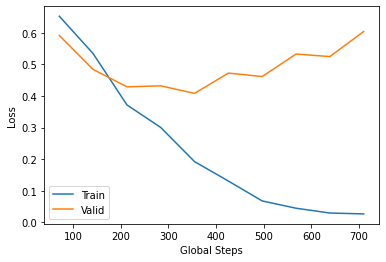

In [0]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/title_metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

## Text Only

In [0]:
model_text = WORD2VEC_Single().to(device)
optimizer = optim.Adam(model_text.parameters(), lr=0.001)

train(model=model_text, optimizer=optimizer, version='text')

Epoch [1/5], Step [71/710], Train Loss: 0.6295, Valid Loss: 0.4634
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/Word2Vec/text_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/Word2Vec/text_metrics.pt
Epoch [1/5], Step [142/710], Train Loss: 0.4236, Valid Loss: 0.3436
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/Word2Vec/text_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/Word2Vec/text_metrics.pt
Epoch [2/5], Step [213/710], Train Loss: 0.2793, Valid Loss: 0.2637
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/Word2Vec/text_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/Word2Vec/text_metrics.pt
Epoch [2/5], Step [284/710], Train Loss: 0.2120, Valid Loss: 0.2394
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/Word2Vec/text_model.pt
Model saved to ==> /content/dr

Model loaded from <== /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/Word2Vec/text_metrics.pt


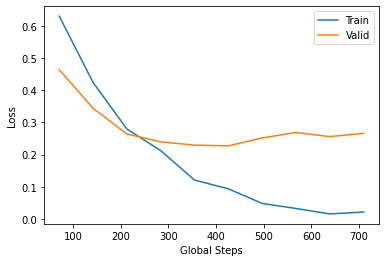

In [0]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/text_metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

## Title-Text Concatenation

In [0]:
model_titletext = WORD2VEC_Single().to(device)
optimizer = optim.Adam(model_titletext.parameters(), lr=0.001)

train(model=model_titletext, optimizer=optimizer, version='titletext')

Epoch [1/5], Step [71/710], Train Loss: 0.6764, Valid Loss: 0.6100
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/Word2Vec/titletext_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/Word2Vec/titletext_metrics.pt
Epoch [1/5], Step [142/710], Train Loss: 0.5483, Valid Loss: 0.4076
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/Word2Vec/titletext_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/Word2Vec/titletext_metrics.pt
Epoch [2/5], Step [213/710], Train Loss: 0.3292, Valid Loss: 0.2942
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/Word2Vec/titletext_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/Word2Vec/titletext_metrics.pt
Epoch [2/5], Step [284/710], Train Loss: 0.2686, Valid Loss: 0.3237
Epoch [3/5], Step [355/710], Train Loss: 0.1518, Valid Loss: 0.2572
Model saved to ==> /content/dri

Model loaded from <== /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/Word2Vec/titletext_metrics.pt


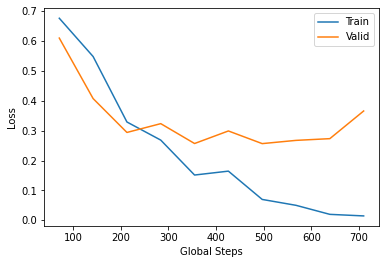

In [0]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/titletext_metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

## Title and Text

In [0]:
model_titleandtext = WORD2VEC_Double().to(device)
optimizer = optim.Adam(model_titleandtext.parameters(), lr=0.001)

train(model=model_titleandtext, optimizer=optimizer, version='titleandtext')

Epoch [1/5], Step [71/710], Train Loss: 0.6127, Valid Loss: 0.4434
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/Word2Vec/titleandtext_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/Word2Vec/titleandtext_metrics.pt
Epoch [1/5], Step [142/710], Train Loss: 0.4122, Valid Loss: 0.3042
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/Word2Vec/titleandtext_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/Word2Vec/titleandtext_metrics.pt
Epoch [2/5], Step [213/710], Train Loss: 0.2346, Valid Loss: 0.2289
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/Word2Vec/titleandtext_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/Word2Vec/titleandtext_metrics.pt
Epoch [2/5], Step [284/710], Train Loss: 0.1608, Valid Loss: 0.2046
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/Word2

Model loaded from <== /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/Word2Vec/titleandtext_metrics.pt


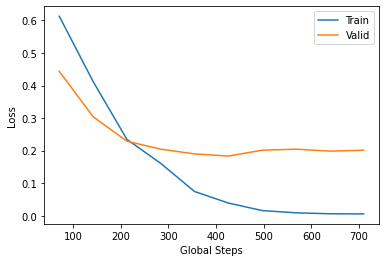

In [0]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/titleandtext_metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

# Evaluation

In [0]:
# Evaluation Function

def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, (title, title_len), (text, text_len), (titletext, titletext_len)), _ in test_loader:           
            labels = labels.to(device)

            if version == 'title':
                title = title.to(device)
                title_len = title_len.to(device)
                output = model(title, title_len)
            elif version == 'text':
                text = text.to(device)
                text_len = text_len.to(device)
                output = model(text, text_len)
            elif version == 'titletext':
                titletext = titletext.to(device)
                titletext_len = titletext_len.to(device)
                output = model(titletext, titletext_len)
            else:
                title = title.to(device)
                title_len = title_len.to(device)
                text = text.to(device)
                text_len = text_len.to(device)
                output = model(title, title_len, text, text_len)

            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])

Model loaded from <== /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/Word2Vec/title_model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.8436    0.8275    0.8355       313
           0     0.8333    0.8491    0.8411       318

    accuracy                         0.8384       631
   macro avg     0.8385    0.8383    0.8383       631
weighted avg     0.8384    0.8384    0.8383       631



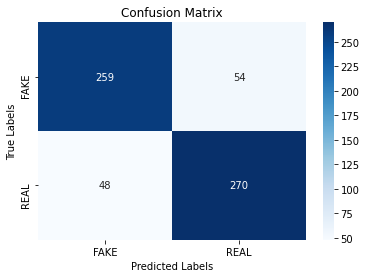

In [14]:
model_title = WORD2VEC_Single().to(device)
optimizer = optim.Adam(model_title.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/title_model.pt', model_title, optimizer)
evaluate(model_title, test_iter, version='title')

Model loaded from <== /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/Word2Vec/text_model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.9323    0.9233    0.9278       313
           0     0.9252    0.9340    0.9296       318

    accuracy                         0.9287       631
   macro avg     0.9287    0.9286    0.9287       631
weighted avg     0.9287    0.9287    0.9287       631



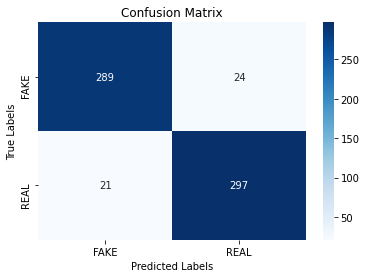

In [15]:
model_text = WORD2VEC_Single().to(device)
optimizer = optim.Adam(model_text.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/text_model.pt', model_text, optimizer)
evaluate(model_text, test_iter, version='text')

Model loaded from <== /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/Word2Vec/titletext_model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.9203    0.8850    0.9023       313
           0     0.8909    0.9245    0.9074       318

    accuracy                         0.9049       631
   macro avg     0.9056    0.9048    0.9048       631
weighted avg     0.9055    0.9049    0.9049       631



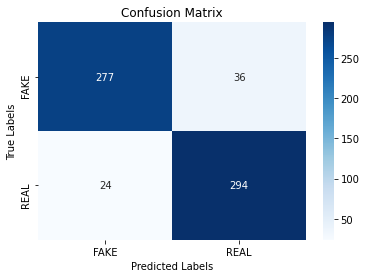

In [16]:
model_titletext = WORD2VEC_Single().to(device)
optimizer = optim.Adam(model_titletext.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/titletext_model.pt', model_titletext, optimizer)
evaluate(model_titletext, test_iter, version='titletext')

Model loaded from <== /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/Word2Vec/titleandtext_model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.9433    0.9042    0.9233       313
           0     0.9094    0.9465    0.9276       318

    accuracy                         0.9255       631
   macro avg     0.9263    0.9253    0.9255       631
weighted avg     0.9262    0.9255    0.9255       631



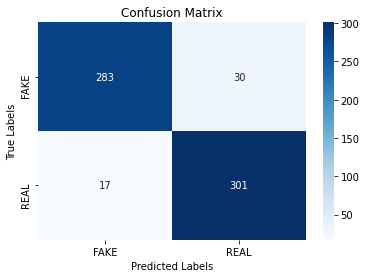

In [18]:
model_titleandtext = WORD2VEC_Double().to(device)
optimizer = optim.Adam(model_titleandtext.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/titleandtext_model.pt', model_titleandtext, optimizer)
evaluate(model_titleandtext, test_iter, version='titleandtext')